# Human Facial Emotions Detection

---

**Dataset:** [FER2013](https://www.kaggle.com/msambare/fer2013)\
**Auhtor:** Dmitry Luchkin\
**Date:** 2025-02-28

---

This project focuses on detecting emotions from facial images using a Convolutional Neural Network (CNN). The model is trained on labeled facial expressions to classify emotions such as happiness, sadness, anger, surprise, and more. This can be applied in various domains, including human-computer interaction, sentiment analysis, and mental health monitoring.

### Objective

The goal is to develop a robust deep learning model capable of accurately classifying facial emotions. The models evaluated in this project include:

- Convolutional Neural Networks (CNN)
- Data Augmentation for better generalization

### Project Workflow

1. **Data Collection & Preprocessing**
   - Downloading and loading the dataset
   - Data augmentation techniques for better generalization
2. **Exploratory Data Analysis (EDA)**
   - Visualizing dataset distribution
   - Identifying class imbalances
3. **Model Training & Evaluation**
   - Splitting the dataset into training, validation, and test sets
   - Training CNN from scratch and evaluating performance
   - Performance evaluation using metrics:
     - Accuracy
     - F1-Score
     - ROC-AUC Score
4. **Model Selection & Optimization**
   - Selecting the best model based on evaluation metrics
   - Optimizing model performance using hyperparameter tuning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import random

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = info, 2 = warnings, 3 = errors

import tensorflow as tf

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment
    # variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [5]:
tf.__version__

'2.18.0'

In [6]:
# to reproduce
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data Loading

In [7]:
BATCH = 64
IMAGE_SIZE = (48, 48)

In [8]:
# training set
train_dataset = image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train",
    labels="inferred",
    image_size=IMAGE_SIZE,
    batch_size=BATCH,
    label_mode="int",
    color_mode="grayscale",
    shuffle=True,
    validation_split=0.25,
    subset="training",
    seed=SEED
)
# validation set
val_dataset = image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train",
    labels="inferred",
    image_size=IMAGE_SIZE,
    batch_size=BATCH,
    label_mode="int",
    color_mode="grayscale",
    shuffle=True,
    validation_split=0.25,
    subset="validation",
    seed=SEED
)
# test set
test_dataset = image_dataset_from_directory(
    "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test",
    labels="inferred",
    image_size=IMAGE_SIZE,
    batch_size=BATCH,
    label_mode="int",
    color_mode="grayscale",
    shuffle=True
)

Found 28709 files belonging to 7 classes.
Using 21532 files for training.
Found 28709 files belonging to 7 classes.
Using 7177 files for validation.
Found 7178 files belonging to 7 classes.


In [9]:
class_names = test_dataset.class_names
print(f"Classes: {class_names})")

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])


## Classes balance

In [10]:
# check classes balance
class_counts = {class_name: 0 for class_name in train_dataset.class_names}
all_labels = []

for images, labels in train_dataset:
    for i in range(len(labels)):
        class_name = class_names[labels[i]]
        class_counts[class_name] += 1
        all_labels.append(labels[i])

all_labels = np.array(all_labels)
print(class_counts)

{'angry': 3017, 'disgust': 344, 'fear': 3066, 'happy': 5468, 'neutral': 3703, 'sad': 3591, 'surprise': 2343}


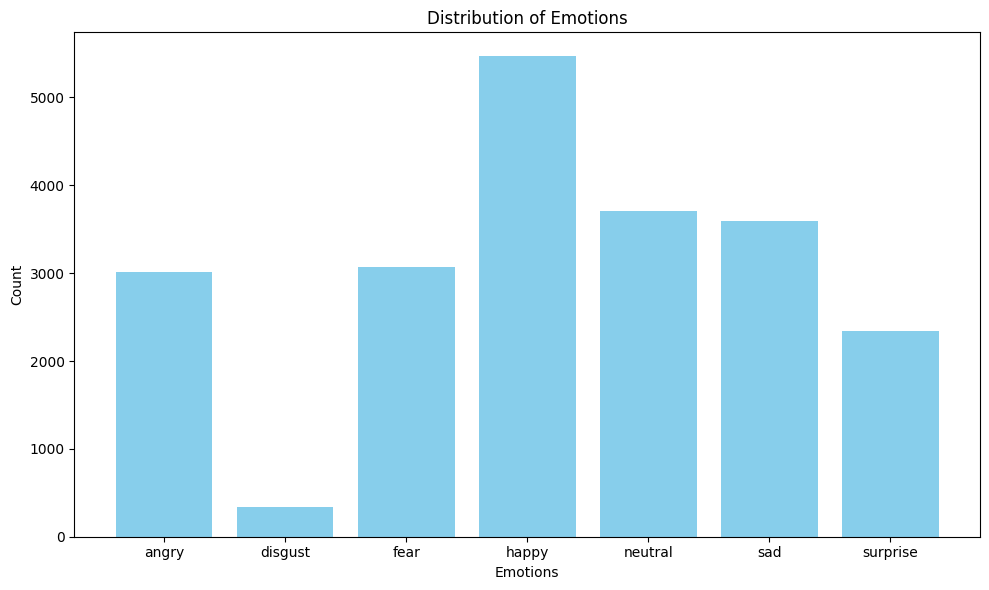

In [11]:
emotions = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.tight_layout()
plt.show()

In [12]:
from sklearn.utils import class_weight

# Check weights of the classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 1.0195558501823003,
 1: 8.94186046511628,
 2: 1.0032615786040444,
 3: 0.562545720555962,
 4: 0.8306778287874697,
 5: 0.8565859092174881,
 6: 1.31284677763551}

## Model Acrchitecture

In [13]:

# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = tf.keras.Sequential([
        # Data Augmentation
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", input_shape=(48, 48, 1),
            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.1),

        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #tf.keras.layers.Dropout(0.1), # UPD 1

        tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same", activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.1), # UPD 4 0.2 -> 0.1

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Dense(256, activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dropout(0.25), # UPD 2 # UPD 3

        tf.keras.layers.Dense(7, activation="softmax")
    ])

## Model Training

In [14]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"], steps_per_execution=64)

# speed up the training
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


early_stop = EarlyStopping(monitor="val_loss",
                           patience=7,
                           restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss",
                                 factor=0.5,
                                 patience=3,
                                 min_lr=1e-6)

# save the wights of the best model
checkpoint_callback = ModelCheckpoint(
    #filepath='./01_models/v1/model.v1.weights.h5',
    filepath='model.v1.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)
# training the model
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    batch_size=BATCH,
                    epochs=100,
                    callbacks=[lr_scheduler, early_stop, checkpoint_callback],
                    class_weight=class_weight_dict)

Epoch 1/100
321/337 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1607 - loss: 4.2778
Epoch 1: val_accuracy improved from -inf to 0.17124, saving model to model.v1.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 50s 86ms/step - accuracy: 0.1609 - loss: 4.2746 - val_accuracy: 0.1712 - val_loss: 3.9415 - learning_rate: 1.0000e-04
Epoch 2/100
321/337 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.1777 - loss: 4.0100
Epoch 2: val_accuracy improved from 0.17124 to 0.24439, saving model to model.v1.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.1777 - loss: 4.0084 - val_accuracy: 0.2444 - val_loss: 3.6060 - learning_rate: 1.0000e-04
Epoch 3/100
321/337 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.1962 - loss: 3.8583
Epoch 3: val_accuracy improved from 0.24439 to 0.24857, saving model to model.v1.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.1964 - loss: 3.8579 - val_accuracy: 0.2486 - val_loss: 3.5647 - learning_rate: 1.0000e-04
Epoch 4/100
321/337 ━━

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 23, 23, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 23, 23, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 33,027,159 (125.99 MB)

 Trainable params: 11,007,431 (41.99 MB)

 Non-trainable params: 4,864 (19.00 KB)

 Optimizer params: 22,014,864 (83.98 MB)

## Model Evaluation

In [16]:
# load the best weights
#model.load_weights('./01_models/v1/model.v1.weights.h5')
model.load_weights('model.v1.weights.h5')

train_loss, train_acc = model.evaluate(train_dataset)
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")

val_loss, val_acc = model.evaluate(val_dataset)
print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_acc}")

# evaluate on test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7412 - loss: 1.0874
Train Loss: 1.0848758220672607
Train Accuracy: 0.7422441244125366
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6375 - loss: 1.4143 
Val Loss: 1.4142179489135742
Val Accuracy: 0.6374529600143433
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6389 - loss: 1.4007
Test Loss: 1.4006003141403198
Test Accuracy: 0.638896644115448


In [17]:
# save the best model architecture
model_json = model.to_json()
#with open("./01_models/v1/best_model.v1.json", "w") as json_file:
with open("best_model.v1.json", "w") as json_file:
    json_file.write(model_json)

## Model Performance

In [18]:
test_labels = []

for images, labels in test_dataset:
    for i in range(len(labels)):
        test_labels.append(labels[i])

test_labels = np.array(test_labels)

In [19]:
from sklearn.metrics import f1_score

y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(test_labels, y_pred_labels, average='weighted')
print("Test F1 Score:", f1)


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step
Test F1 Score: 0.639476520484305


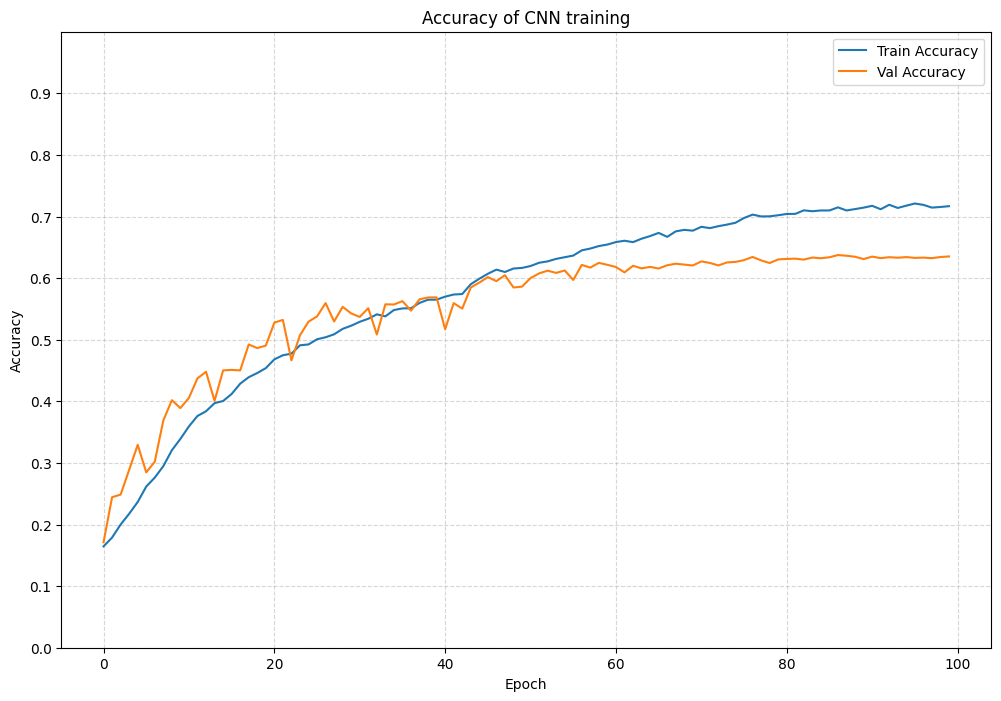

In [20]:
plt.figure(figsize=(12, 8))
# learning process
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim((0, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.title("Accuracy of CNN training")
plt.show()

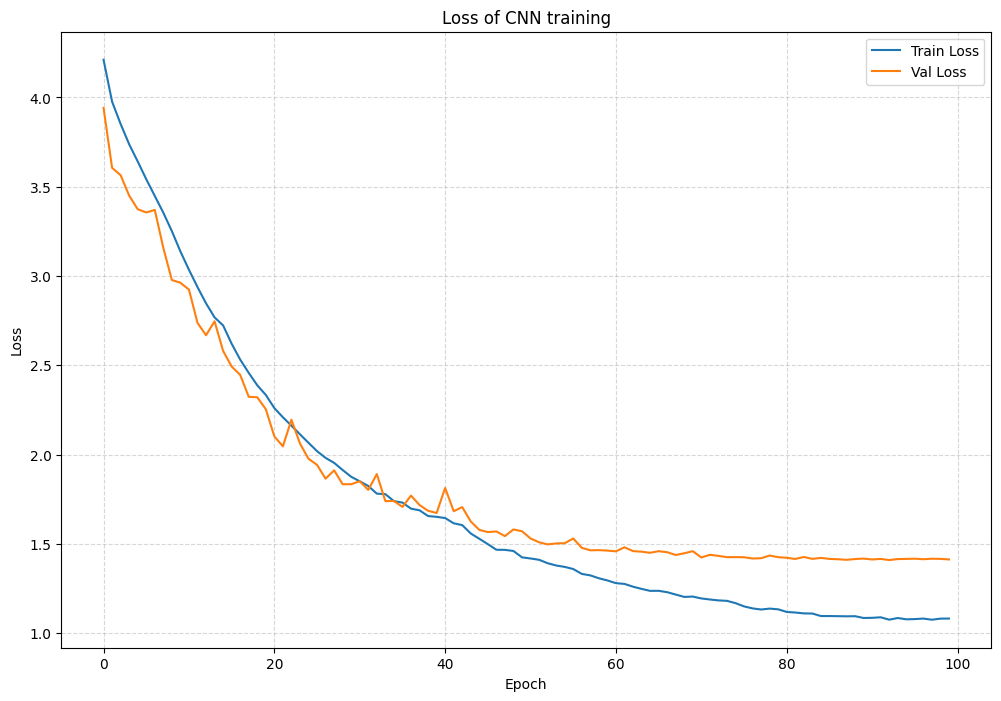

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.title("Loss of CNN training")
plt.show()

In [22]:
# predict of test set
y_pred = model.predict(test_dataset)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 


In [23]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')

print(f"ROC-AUC for test set: {roc_auc:.4f}")

ROC-AUC for test set: 0.9027


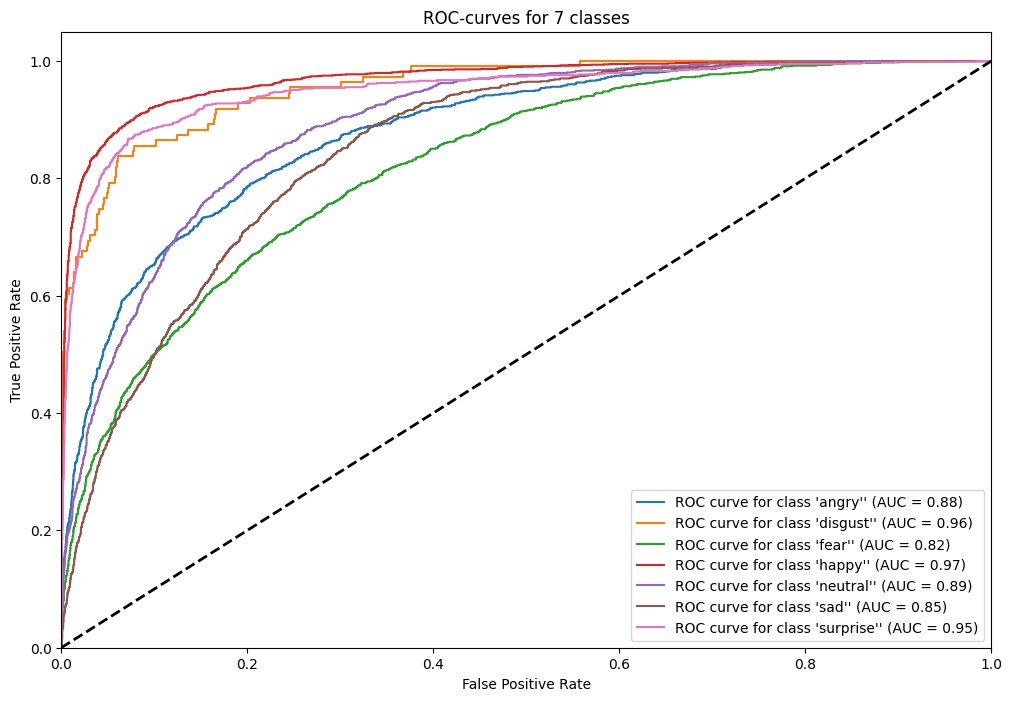

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 7
y_true_bin = label_binarize(test_labels, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"ROC curve for class '{class_names[i]}'' (AUC = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curves for 7 classes')
plt.legend(loc="lower right")
plt.show()


<Figure size 1200x800 with 0 Axes>

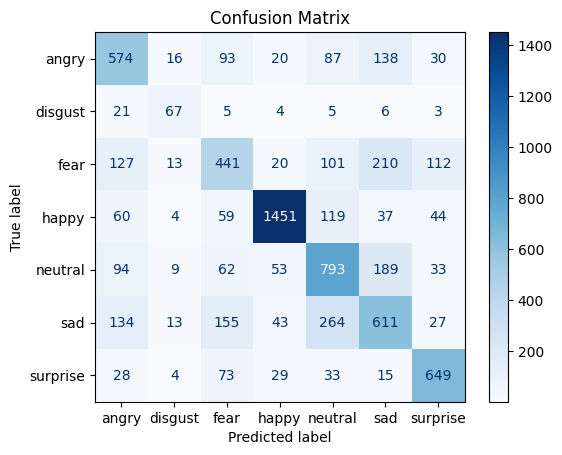

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(12, 8))

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Confusion Matrix")

plt.show()

## Single Prediction

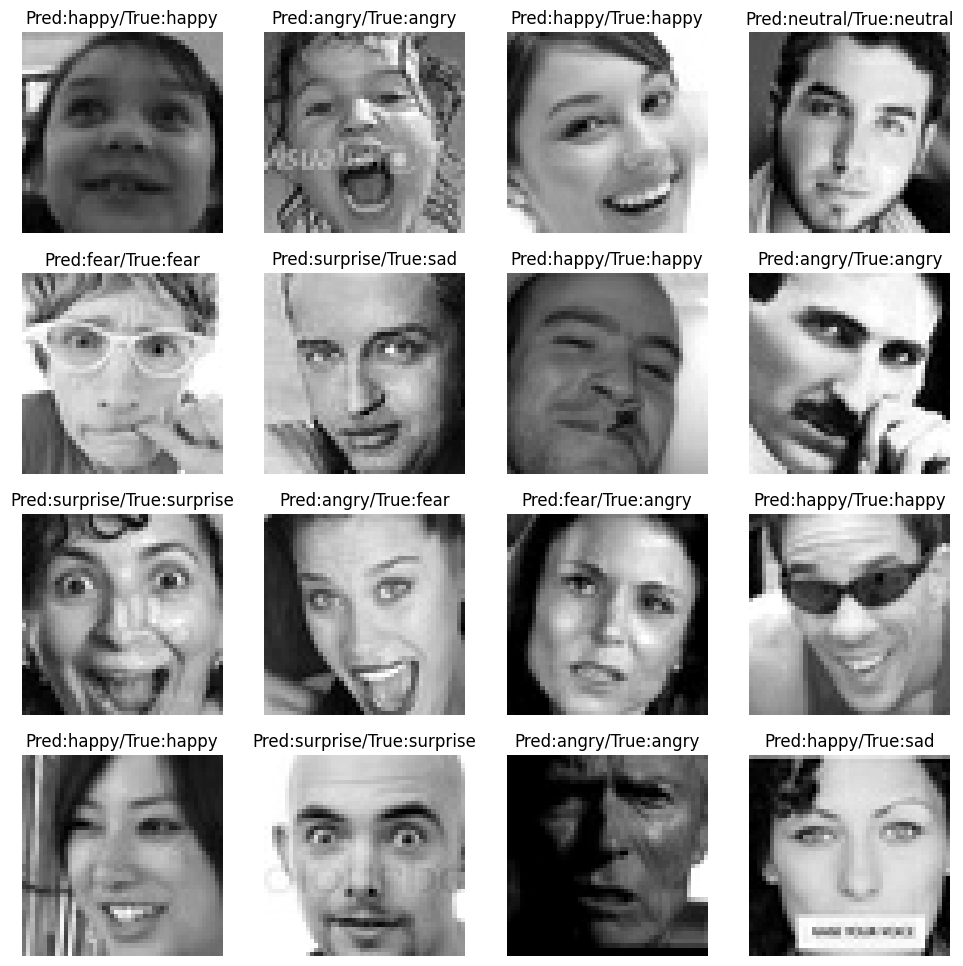

In [27]:
from tensorflow.keras.preprocessing import image
plt.figure(figsize=(12, 12))

for images, labels in test_dataset.take(5):
    for i in range(16):
        plt.subplot(4, 4, i + 1)

        img_x = image.img_to_array(images[i])
        img_x = np.expand_dims(img_x, axis=0)

        plt.imshow(images[i], cmap="gray")
        # predict
        result = model.predict(img_x, verbose=False)

        prediction = class_names[np.argmax(result)]

        plt.title(f"Pred:{prediction}/True:{class_names[labels[i]]}")
        plt.axis("off")

plt.show()